# Lab 9 - Graph Data Analytics

Complete the code with TODO tag.

If you haven't installed networkx package, you can run the following command (note the exclamation mark)

```bash
!conda install networkx --yes
```

## 1. Centrality Analysis
In this exercise, you will implement the pagerank centrality.

In [23]:
# !pip install networkx==3.0

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree: 4.5882


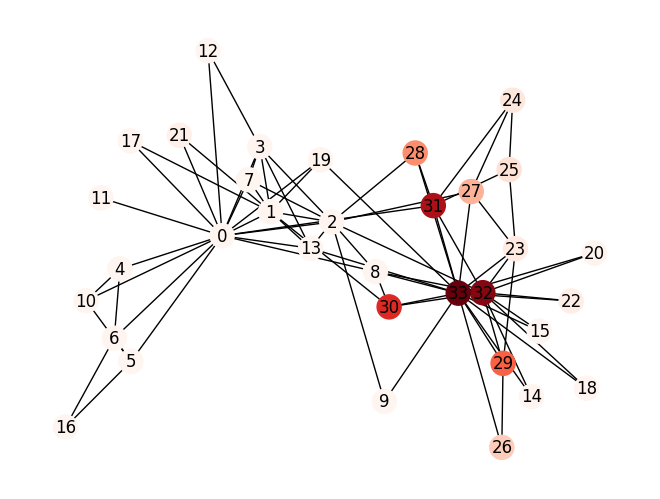

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def pagerank_centrality(G, iter=100):
    p = np.array([1 for i in G.nodes()])
    
    for k in range(iter):
        for i in G.nodes():
            for j in G.nodes():
                # TODO: update the centrality
                p[i] += p[j] / len(list(G.neighbors(j)))
        
        # TODO: Normalize the centrality value to avoid overflow of numerical computation
        norm = sum(p)
        p = p / norm        
    return p

G = nx.karate_club_graph()


name = "Zachary's Karate Club"
type = "Graph"
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
avg_degree = sum(dict(nx.degree(G)).values()) / num_nodes

print("Name: {}".format(name))
print("Type: {}".format(type))
print("Number of nodes: {}".format(num_nodes))
print("Number of edges: {}".format(num_edges))
print("Average degree: {:.4f}".format(avg_degree))

values = pagerank_centrality(G)
nx.draw(G, cmap=plt.get_cmap('Reds'), node_color = values, with_labels=True)

## 2. Community Analysis

### 2.1. Clique Percolation Method

One well-known algorithm for detecting overlapping communities is called the Clique Percolation Method (CPM).

In [25]:
from itertools import combinations

def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    
    cliques = list(nx.find_cliques(G))
    perc_graph.add_nodes_from([frozenset(c) for c in cliques])
    
    for c1, c2 in combinations(perc_graph.nodes(), 2):
        if len(c1 & c2) == k-1:
            perc_graph.add_edge(c1, c2)
        
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

Test with a small dataset

---0.0 seconds---


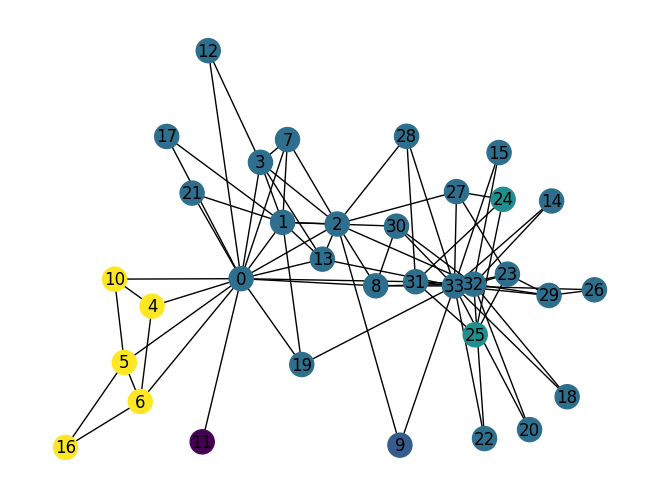

In [26]:
def partition(communities):
    node2communities = dict()
    
    for i, community in enumerate(communities):
        for node in community:
            if node not in node2communities:
                node2communities[node] = []
            node2communities[node].append(i)
    
    for node, communities in node2communities.items():
        node2communities[node] = [hash(str(community)) % 256 for community in communities]
        
    return node2communities

G = nx.karate_club_graph()

import time
start_time = time.time()
communities = get_percolated_cliques(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

part = partition(communities)
values = [part.get(node,[-1])[0] for node in G.nodes()]

nx.draw(G, node_color = values, with_labels=True)

### 2.2. Efficient Implementation
That implementation is correct but expensive---it requires O(N^2) clique comparisons, where N is the number of cliques (which is often much larger than the number of nodes!).  If we use a python dictionary to index which nodes belong to which cliques, then we can easily compare only those cliques that share at least one node in common.  This implementation is a bit longer but should be more efficient:

---0.0 seconds---


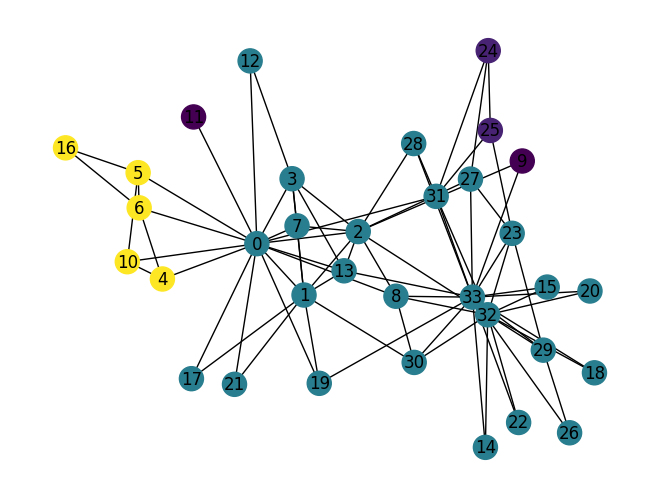

In [27]:
from collections import defaultdict

def get_percolated_cliques2(G, k):
    perc_graph = nx.Graph()
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)

    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    
    for node in clique:
        adjacent_cliques.update(membership_dict[node])
        
    adjacent_cliques.discard(clique)
    
    return adjacent_cliques

G = nx.karate_club_graph()

import time
start_time = time.time()
communities = get_percolated_cliques2(G,3)
print("---{0} seconds---".format(time.time() - start_time))

part = partition(communities)
values = [part.get(node,[-1])[0] for node in G.nodes()]

nx.draw(G, node_color = values, with_labels=True)

### 2.3. Test with large dataset

Now we test with a real large-scale network data at https://snap.stanford.edu/data/com-Amazon.html

In [28]:
# G = nx.read_edgelist("email-Eu-core.txt")
G = nx.read_edgelist("com-amazon.ungraph.txt")

type = "Graph"
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
avg_degree = sum(dict(nx.degree(G)).values()) / num_nodes

print("Type: {}".format(type))
print("Number of nodes: {}".format(num_nodes))
print("Number of edges: {}".format(num_edges))
print("Average degree: {:.4f}".format(avg_degree))

start_time = time.time()
communities = get_percolated_cliques(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

start_time = time.time()
communities = get_percolated_cliques2(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

Type: Graph
Number of nodes: 334863
Number of edges: 925872
Average degree: 5.5299
---0.0 seconds---
---0.0 seconds---
